# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.utils import resample
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
sizes = df.toxic.value_counts()
sizes

0    143346
1     16225
Name: toxic, dtype: int64

Видим большой дисбаланс классов.

In [5]:
# уменьшеие исходной выборки
df = df.sample(frac=0.8, random_state=12345).reset_index(drop=True)
df

,text,toxic
0,Ahh shut the fuck up you douchebag sand nigger...,1
1,"""\n\nREPLY: There is no such thing as Texas Co...",0
2,"Reply\nHey, you could at least mention Jasenov...",0
3,"Thats fine, there is no deadline ) chi?",0
4,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0
...,...,...
127652,"""\n\n Remove NPOV \n\nI guess the days of NPO...",0
127653,"""do you accept the stereotype that women are i...",0
127654,vandalism \n\ndisagree ... you limeys are just...,0
127655,"""\nWelcome!\n\nHello, , and welcome to Wikiped...",0


In [6]:
%%time
wnl = WordNetLemmatizer()

def lemmatize(text):
    """функция лемматизации и очистки текстов"""
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    lemmas = ' '.join([wnl.lemmatize(w) for w in word_list])
    clear = re.sub(r'[^a-zA-Z]', ' ', lemmas) 
    return " ".join(clear.split())

df['lemmas'] = df['text'].apply(lemmatize)
df = df.drop(['text'], axis=1)

Wall time: 3min 2s


In [7]:
df

,toxic,lemmas
0,1,ahh shut the fuck up you douchebag sand nigger...
1,0,reply there is no such thing a texas commerce ...
2,0,reply hey you could at least mention jasenovac...
3,0,thats fine there is no deadline chi
4,0,dyk nomination of mustarabim hello your submis...
...,...,...
127652,0,remove npov i guess the day of npov are now ov...
127653,0,do you accept the stereotype that woman are in...
127654,0,vandalism disagree you limey are just frustrat...
127655,0,welcome hello and welcome to wikipedia thank y...


### Вывод

Данные подготовлены для обучения моделей.

## Обучение

In [8]:
# разобиваем данные на обучающую и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.25, random_state=12345)

df_train.toxic.value_counts()

# проверка
display(df_train.shape, df_test.shape)

(95742, 2)

(31915, 2)

In [9]:
sizes = df_train.toxic.value_counts()
sizes

0    86012
1     9730
Name: toxic, dtype: int64

In [10]:
size = sizes[0]/sizes[1]
size

8.839876670092497

Выявлен дисбаланс классов на тренировочной выборке. Устраним его.

In [11]:
# увеличение выборки для устранения дисбаланса
df_train_ds = resample(df_train[df_train['toxic'] == 1], replace=True, n_samples=sizes[0], random_state=12345)
df_train = pd.concat([df_train_ds, df_train[df_train['toxic'] == 0]]).reset_index(drop=True)
df_train['toxic'].value_counts()

1    86012
0    86012
Name: toxic, dtype: int64

In [12]:
features_train = df_train.drop('toxic', axis=1)
features_test = df_test.drop('toxic', axis=1)
target_train = df_train['toxic']
target_test = df_test['toxic']

# проверка
display(features_train.shape, features_test.shape)
display(target_train.shape, target_test.shape)

(172024, 1)

(31915, 1)

(172024,)

(31915,)

In [13]:
# загрузим список стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilyag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Токенизируем строки.

In [14]:
tf_idf = TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords)

In [15]:
features_train = tf_idf.fit_transform(features_train['lemmas'])
features_test = tf_idf.transform(features_test['lemmas'])
display(features_train.shape)
features_test.shape

(172024, 4432270)

(31915, 4432270)

### SGDClassifier

In [16]:
%%time
model_sgd = SGDClassifier(shuffle=True, random_state=12345)
model_sgd.fit(features_train, target_train)
predict_sgd = model_sgd.predict(features_test)
f1_sgd = f1_score(target_test, predict_sgd)
print('f1_score:', f1_sgd)

f1_score: 0.6763817776027308
Wall time: 2.35 s


### LogisticRegression

In [17]:
%%time
model_lr = LogisticRegression(max_iter=1000)
parameters = {'C':[1, 10, 100]}
model_lr_grid = GridSearchCV(model_lr, parameters)
model_lr_grid.fit(features_train, target_train)
predict_lr = model_lr_grid.predict(features_test)
f1_lr = f1_score(target_test, predict_lr)
print('Лучшие параметры логистической регрессии' , model_lr_grid.best_params_)
print('f1_score:', f1_lr)

Лучшие параметры логистической регрессии {'C': 100}
f1_score: 0.7598978288633462
Wall time: 59min


In [18]:
model_dict = {'model_name': ['SGDClassifier',
                             'LogisticRegression'],
             'f1_score': [0.68, 0.76]}
df_result = pd.DataFrame(model_dict).set_index('model_name')
df_result

,f1_score
model_name,
SGDClassifier,0.68
LogisticRegression,0.76


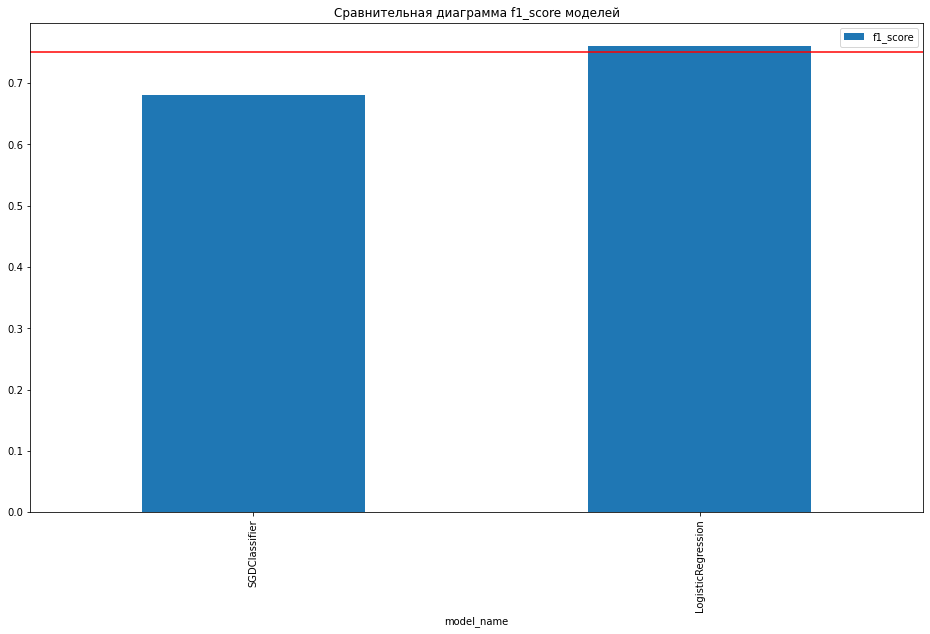

In [19]:
plt.subplot(111)
df_result.plot(kind='bar',
                      figsize=(16,9),
                      title='Сравнительная диаграмма f1_score моделей',
                      ax=plt.gca()).hlines(.75, -1, 5, color='red');

### Выводы

* Обучены и протестированы модели SGDClassifier и LogisticRegression
* Лучший результат на тестовой выборке показала модель LogisticRegression
* Получено целевое значение метрики f1_score 

## Общий вывод

* Была проведена подготовка данных для обучения моделей; выполнена лемматизация, устранён дисбаланс классов
* В качестве токенизатора использовали TF-IDF
* Было получено целевое значение метрики f1 > 0.75
* Лучшее значение метрики f1 показала модель LogisticRegression. f1 = 0.76